In [4]:
%run ../common-imports.ipynb #TODO

# Dataset `classifier-2`

simple dataset will attempt to model it with logistic regression classifier and linear discriminant analysis.

**GOAL**
* Understand the appropriate workflow for classification tasks
* Understand the workings of the logistic regression classifier
* Also, understand the working of linear discriminant analysis

## Exploratory data analysis

We will follow our well-trodden path of systematically load the data, explore and visualize it.

### Load data and observe its statistics

In [5]:
data = pd.read_csv ("../../datasets/classifier-2.csv")
data = data.dropna()
data.describe(include='all').transpose() #.style.set_table_styles(sv_table_styles())

count      mean       std    min      25%    50%       75%     max
x1  4000.0  7.268346  4.312628 -2.806  3.62375  7.732  10.37125  19.585
x2  4000.0  8.258256  3.945063 -1.334  4.56225  8.554  11.66725  19.519
t   4000.0  1.500000  1.118174  0.000  0.75000  1.500   2.25000   3.000

In [6]:
#data.t = data.t.astype('category')

### Visualizations

Let us now plot the data, and observe some of its key qualities.

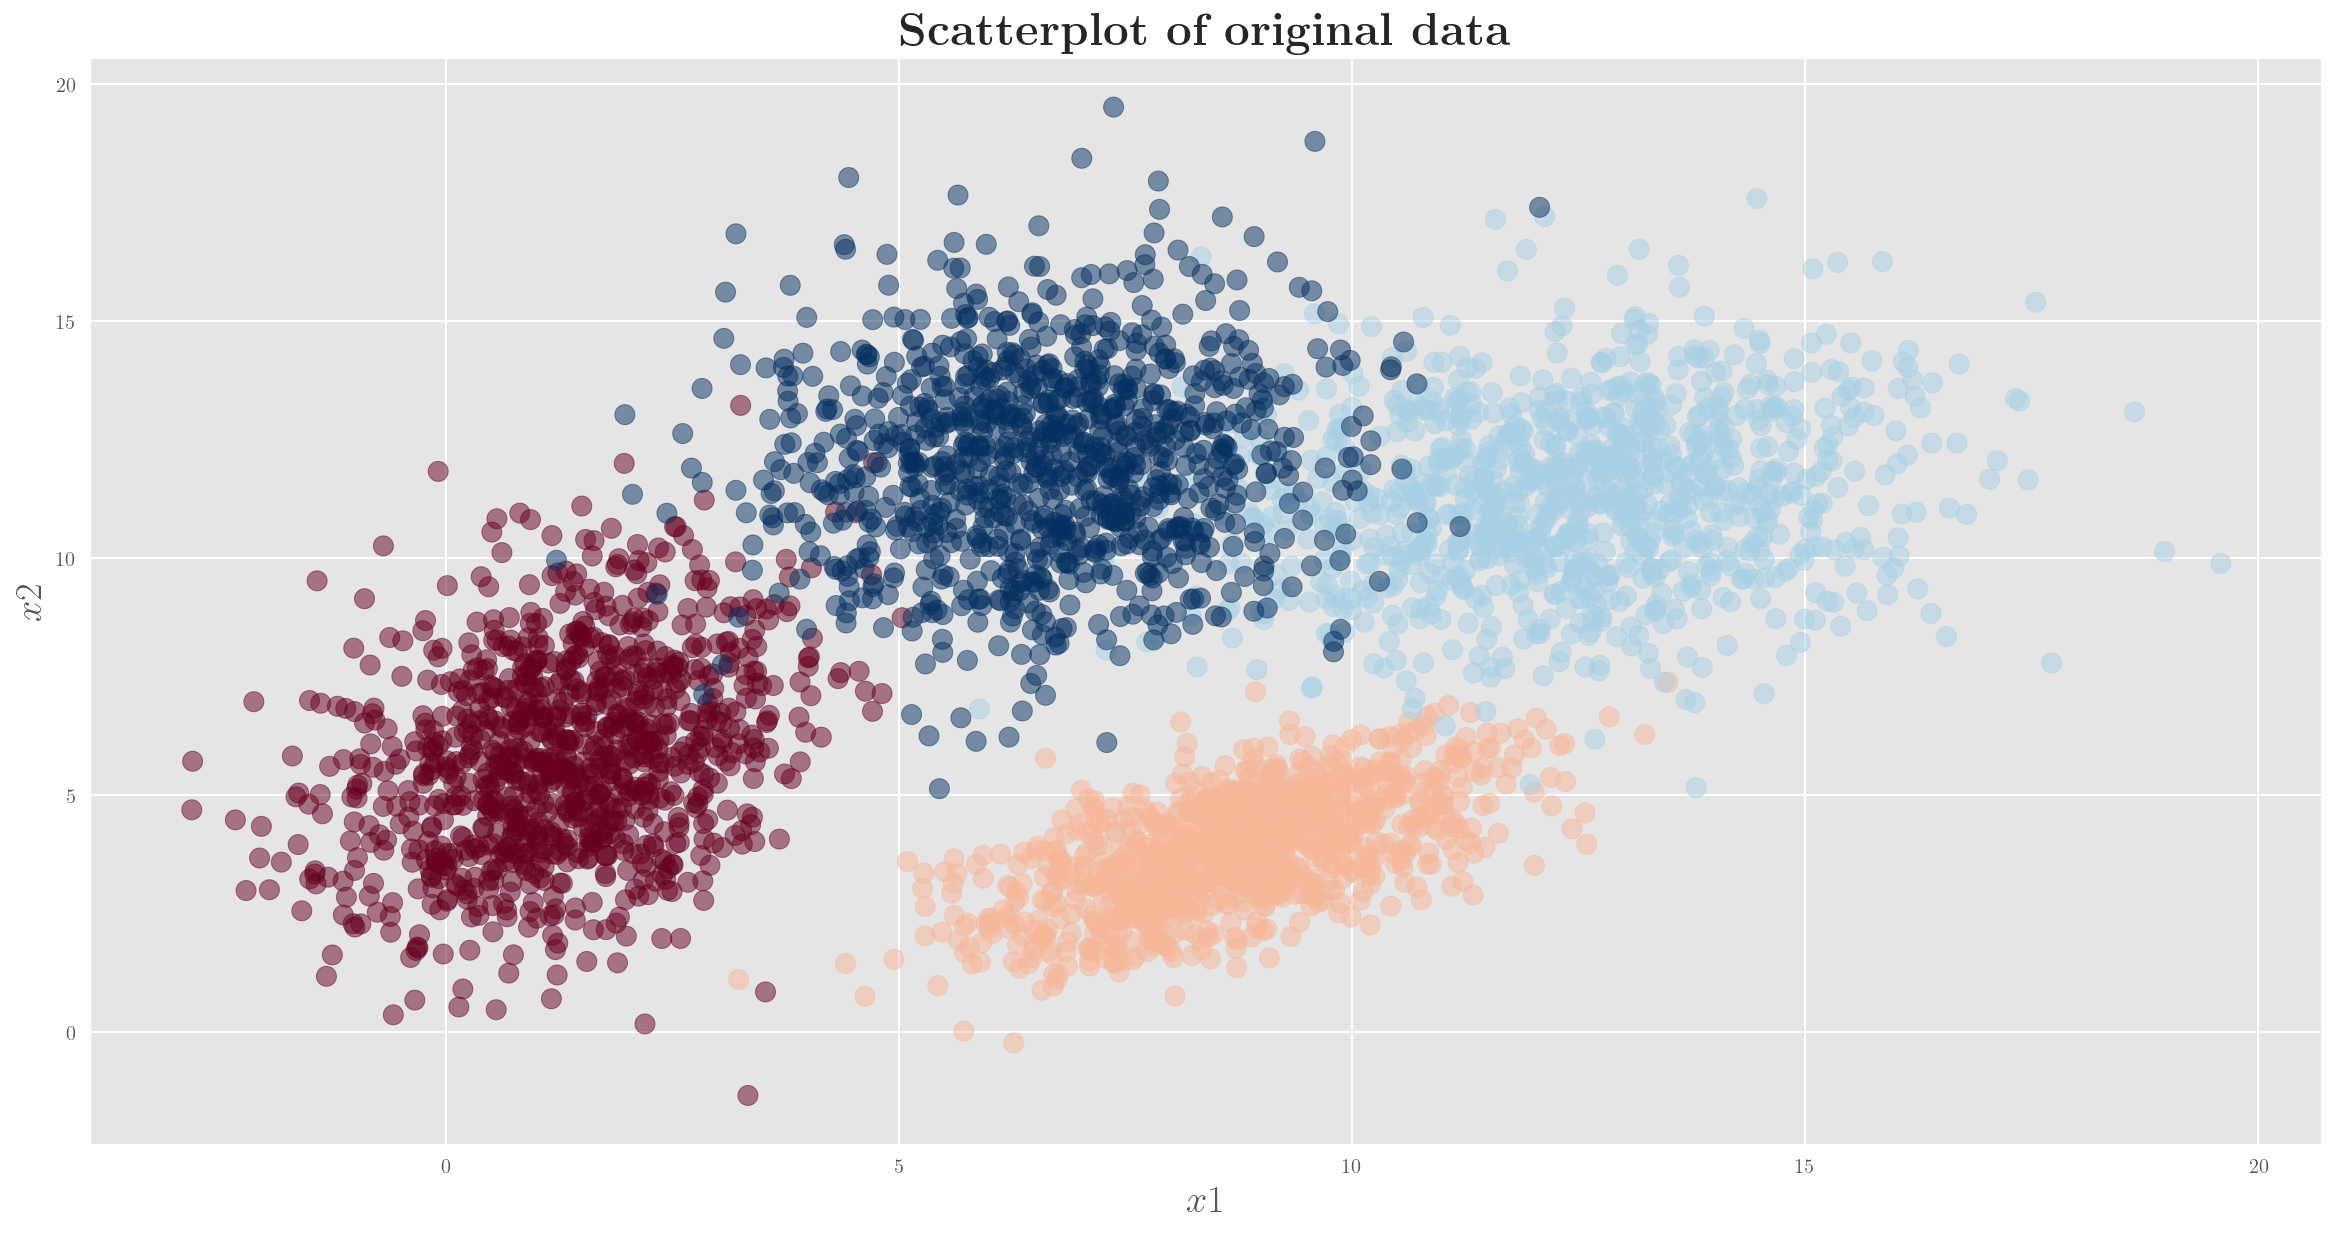

In [7]:
plt.scatter(data['x1'],   # as the x-axis 
            data['x2'],   # as the y-axis
            s=100,
            alpha=0.5, # size
            c=data['t'],
             cmap="RdBu")
plt.xlabel (r"$x1$")
plt.ylabel(r"$x2$")
plt.title(r'\textbf{Scatterplot of original data}')
plt.show ()

The scatterplot above leads us to believe that one may reasonably consider a linear decision boundary, and thus a linear classifier to model this data.

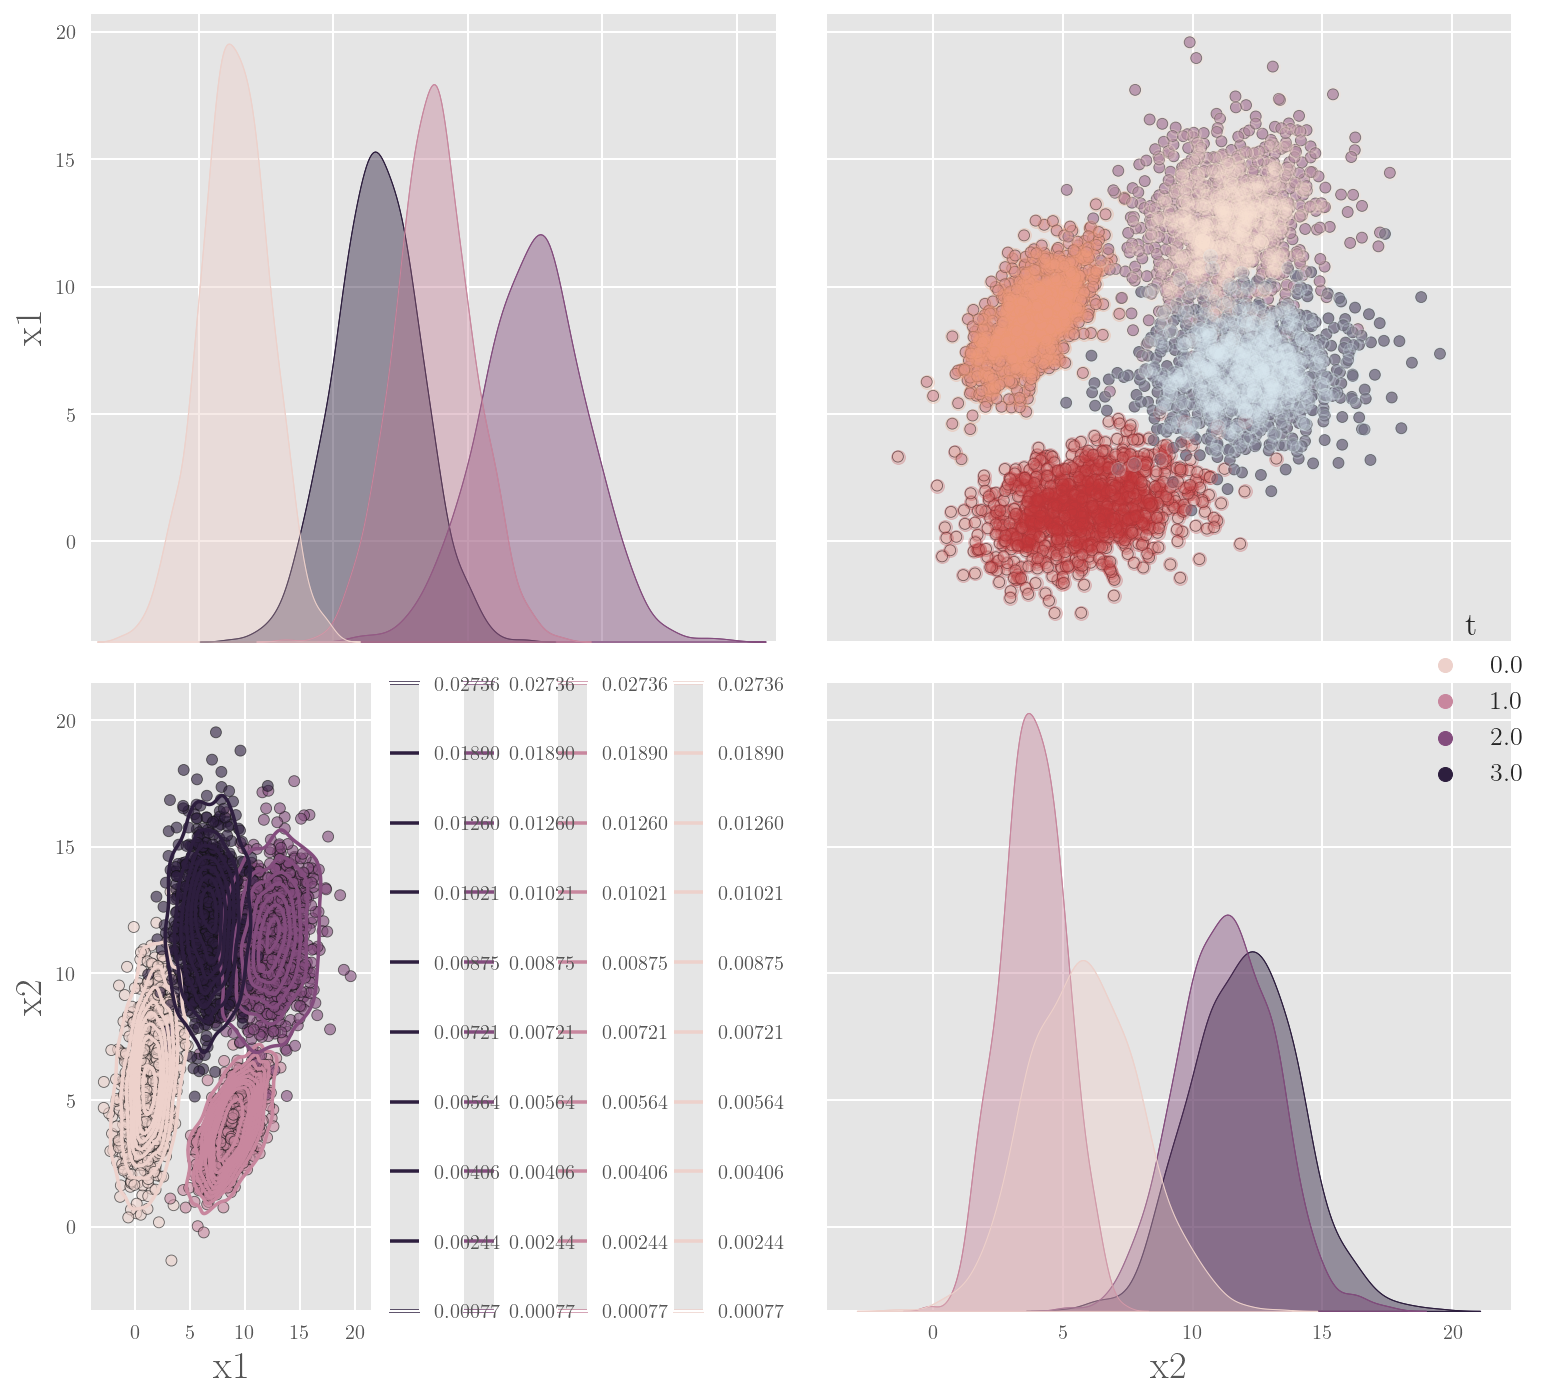

In [8]:
sns.set_palette("RdBu")

sample = data
g = sns.pairplot(sample, diag_kind='kde', 
                   plot_kws = { 'alpha': 0.60, 's': 30, 'edgecolor': 'k',  }, 
                   size=5, hue='t');
g.map_diag(sns.kdeplot,shade=True);
g.map_upper(plt.scatter,   alpha=0.2);
g.map_lower(sns.kdeplot, shade=False, shade_lowest=False, cbar=True);

plt.tight_layout()

Separate out the predictors from the response, and split the data into the training and test subsets.

In [9]:
X, y = data[['x1', 'x2']], data['t']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Logistic Regression Classifier

Let us now attempt to model this data with a logistic regression classifier,on the hypothesis that it may be a linear dataset.

In [10]:
classifier = LogisticRegression(solver='newton-cg')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### Model diagnostics

In [11]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)

[[262   2   0   4]
 [  0 240   0   0]
 [  0   1 225  10]
 [  1   0   8 247]]


In [12]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       268
         1.0       0.99      1.00      0.99       240
         2.0       0.97      0.95      0.96       236
         3.0       0.95      0.96      0.96       256

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [13]:
print("{:15}: {} ".format('Classes',classifier.classes_))
print('{:15}: {} '.format('Coefficients',classifier.coef_))
print('{:15}: {} '.format('Intercept', classifier.intercept_))


Classes        : [0. 1. 2. 3.] 
Coefficients   : [[-2.39687049  0.0947455 ]
 [ 1.3076612  -2.13424138]
 [ 1.4175925   0.8364377 ]
 [-0.32838321  1.20305817]] 
Intercept      : [ 14.06441655   5.76628908 -15.8908423   -3.93986333] 


### Class Probabilities

In the `sklearn` library, the class probabilities can be seen using the `.predict_proba(X)` method. It returns an array whose rows are the predictions for each row of `X`, and the columns are the class probabilities. In the clase of binary classifier, it is enough to retrieve the proabilities of one of the classes, since the other will be the complement of it.

In [14]:
predictions = classifier.predict_proba(X)[:, 1].reshape(y.shape)
yhat = classifier.predict(X)
predictions

array([3.71015278e-09, 3.80519368e-07, 1.26849396e-05, ...,
       8.27088588e-05, 3.96835215e-10, 1.87597057e-07])

The `yellowbrick` library provides a succient visualization of the model metrics.

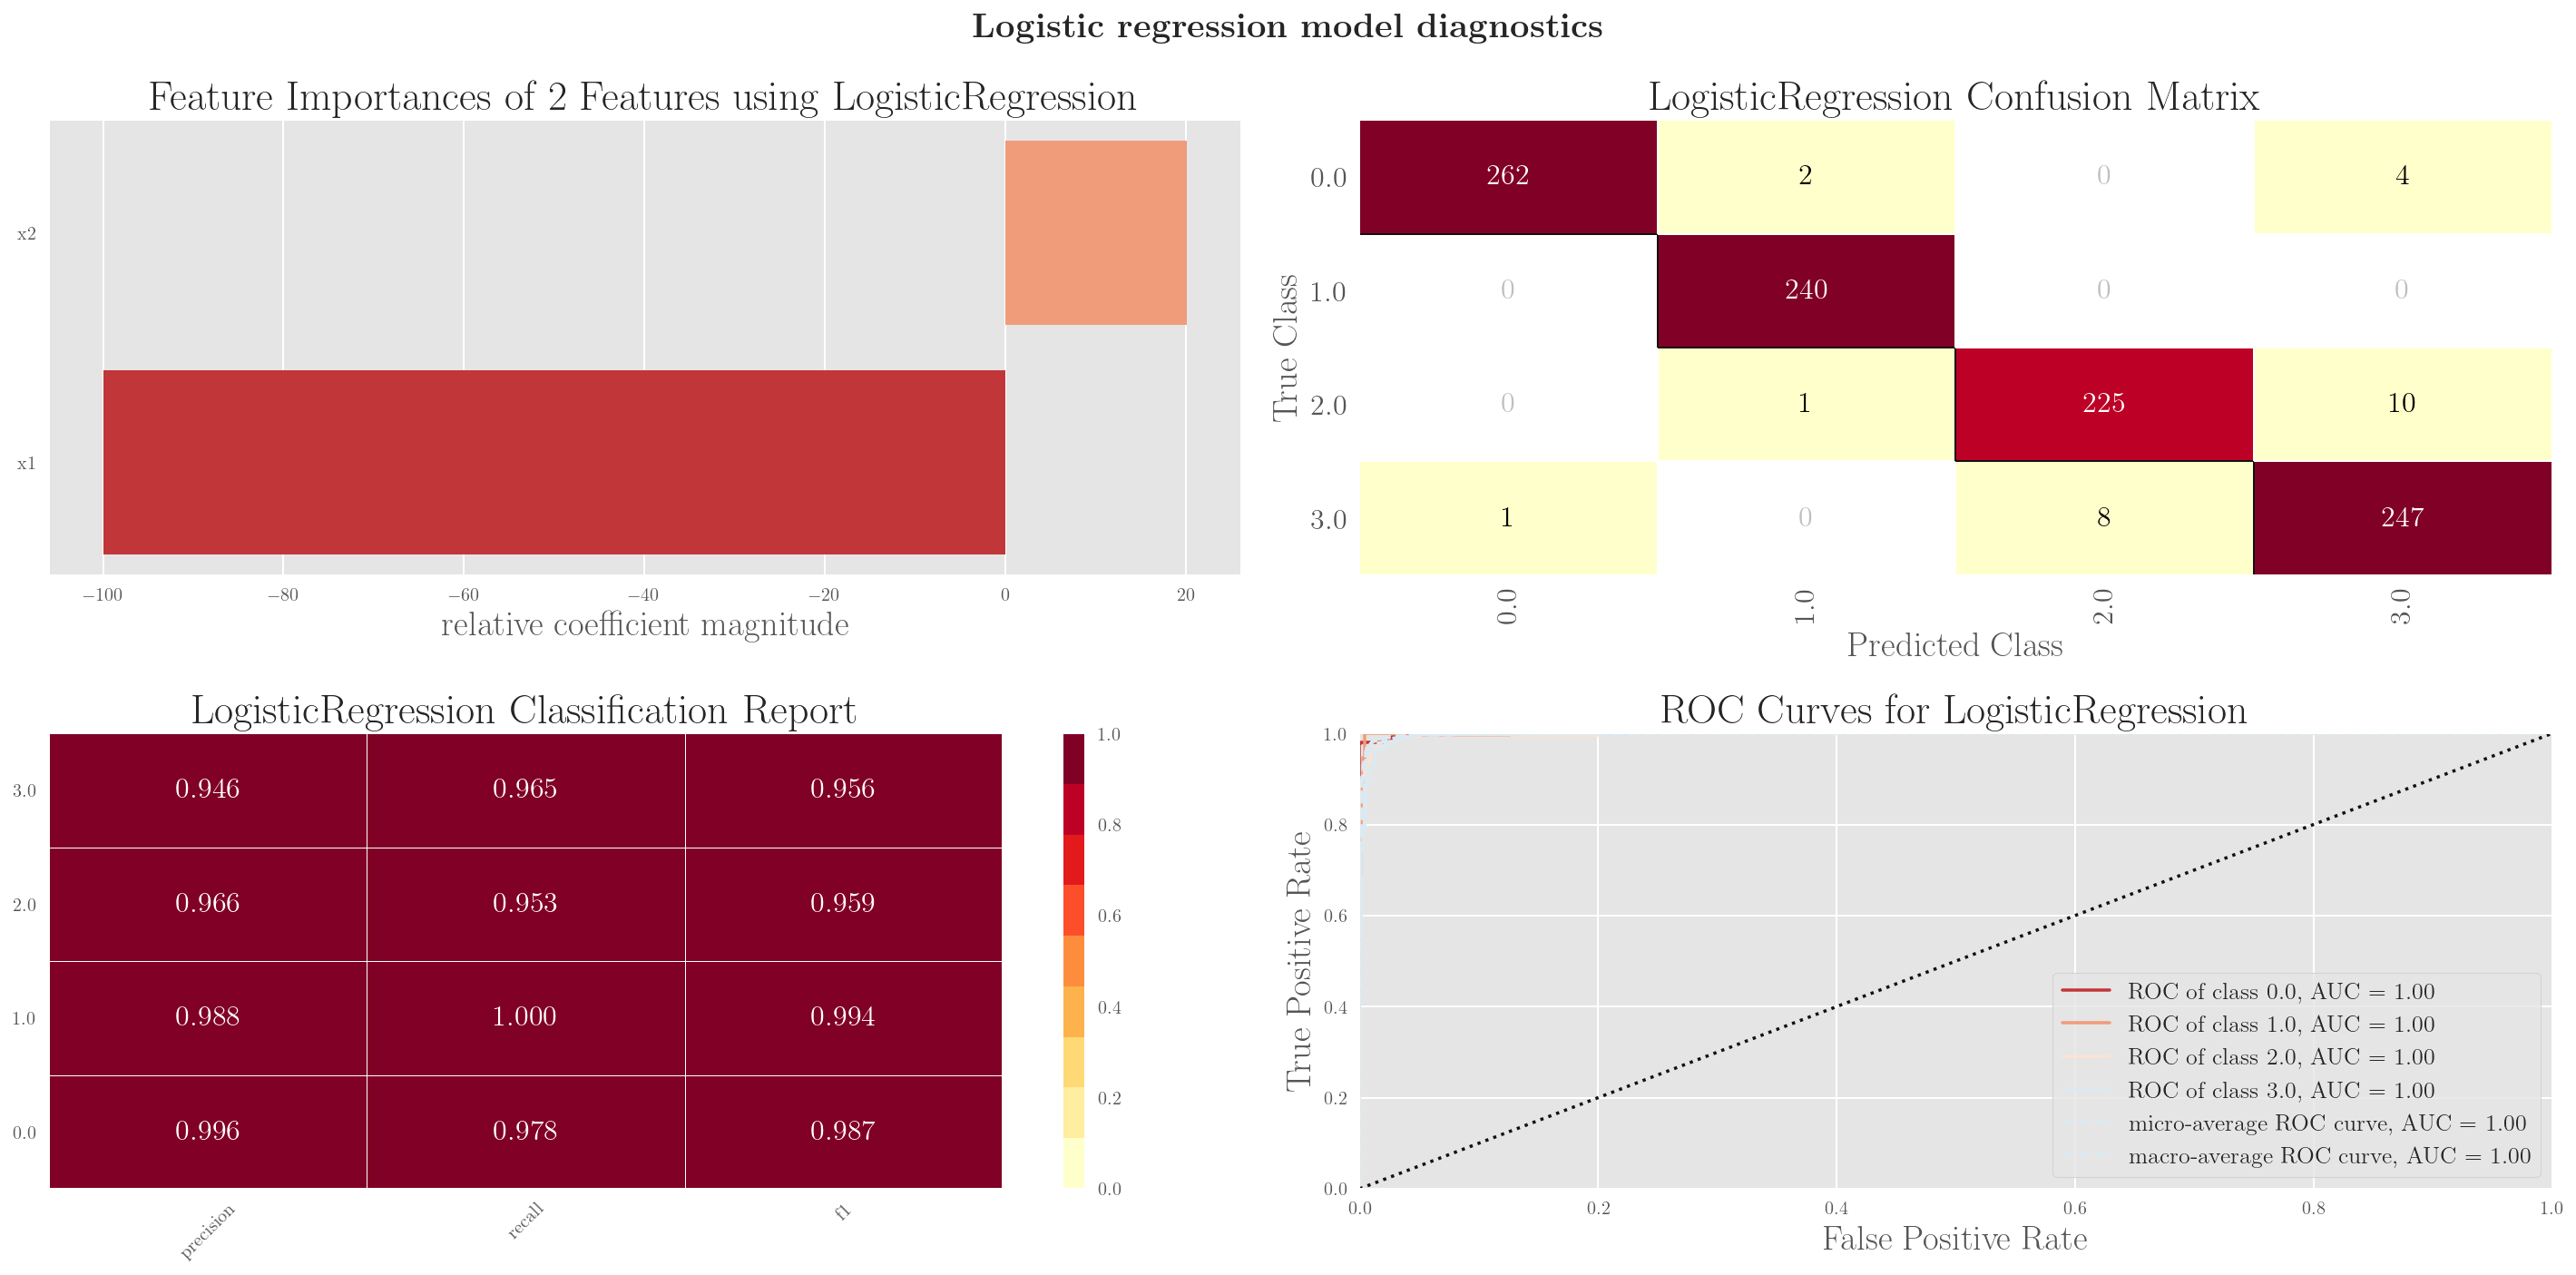

In [15]:

fig, axes = plt.subplots(2, 2)

model = classifier
visualgrid = [
    FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test, )
    viz.finalize()

plt.suptitle(r'\textbf{Logistic regression model diagnostics}');
plt.tight_layout();

The model diagnostics appear to be encouraging. Let us now visualize the model's predictions, and its decision boundary that splits the feature space.

### Visual model predictions

Text(0.5, 1.0, '\\textbf{Scatterplot of original data, along with their predicted class probabilities}')

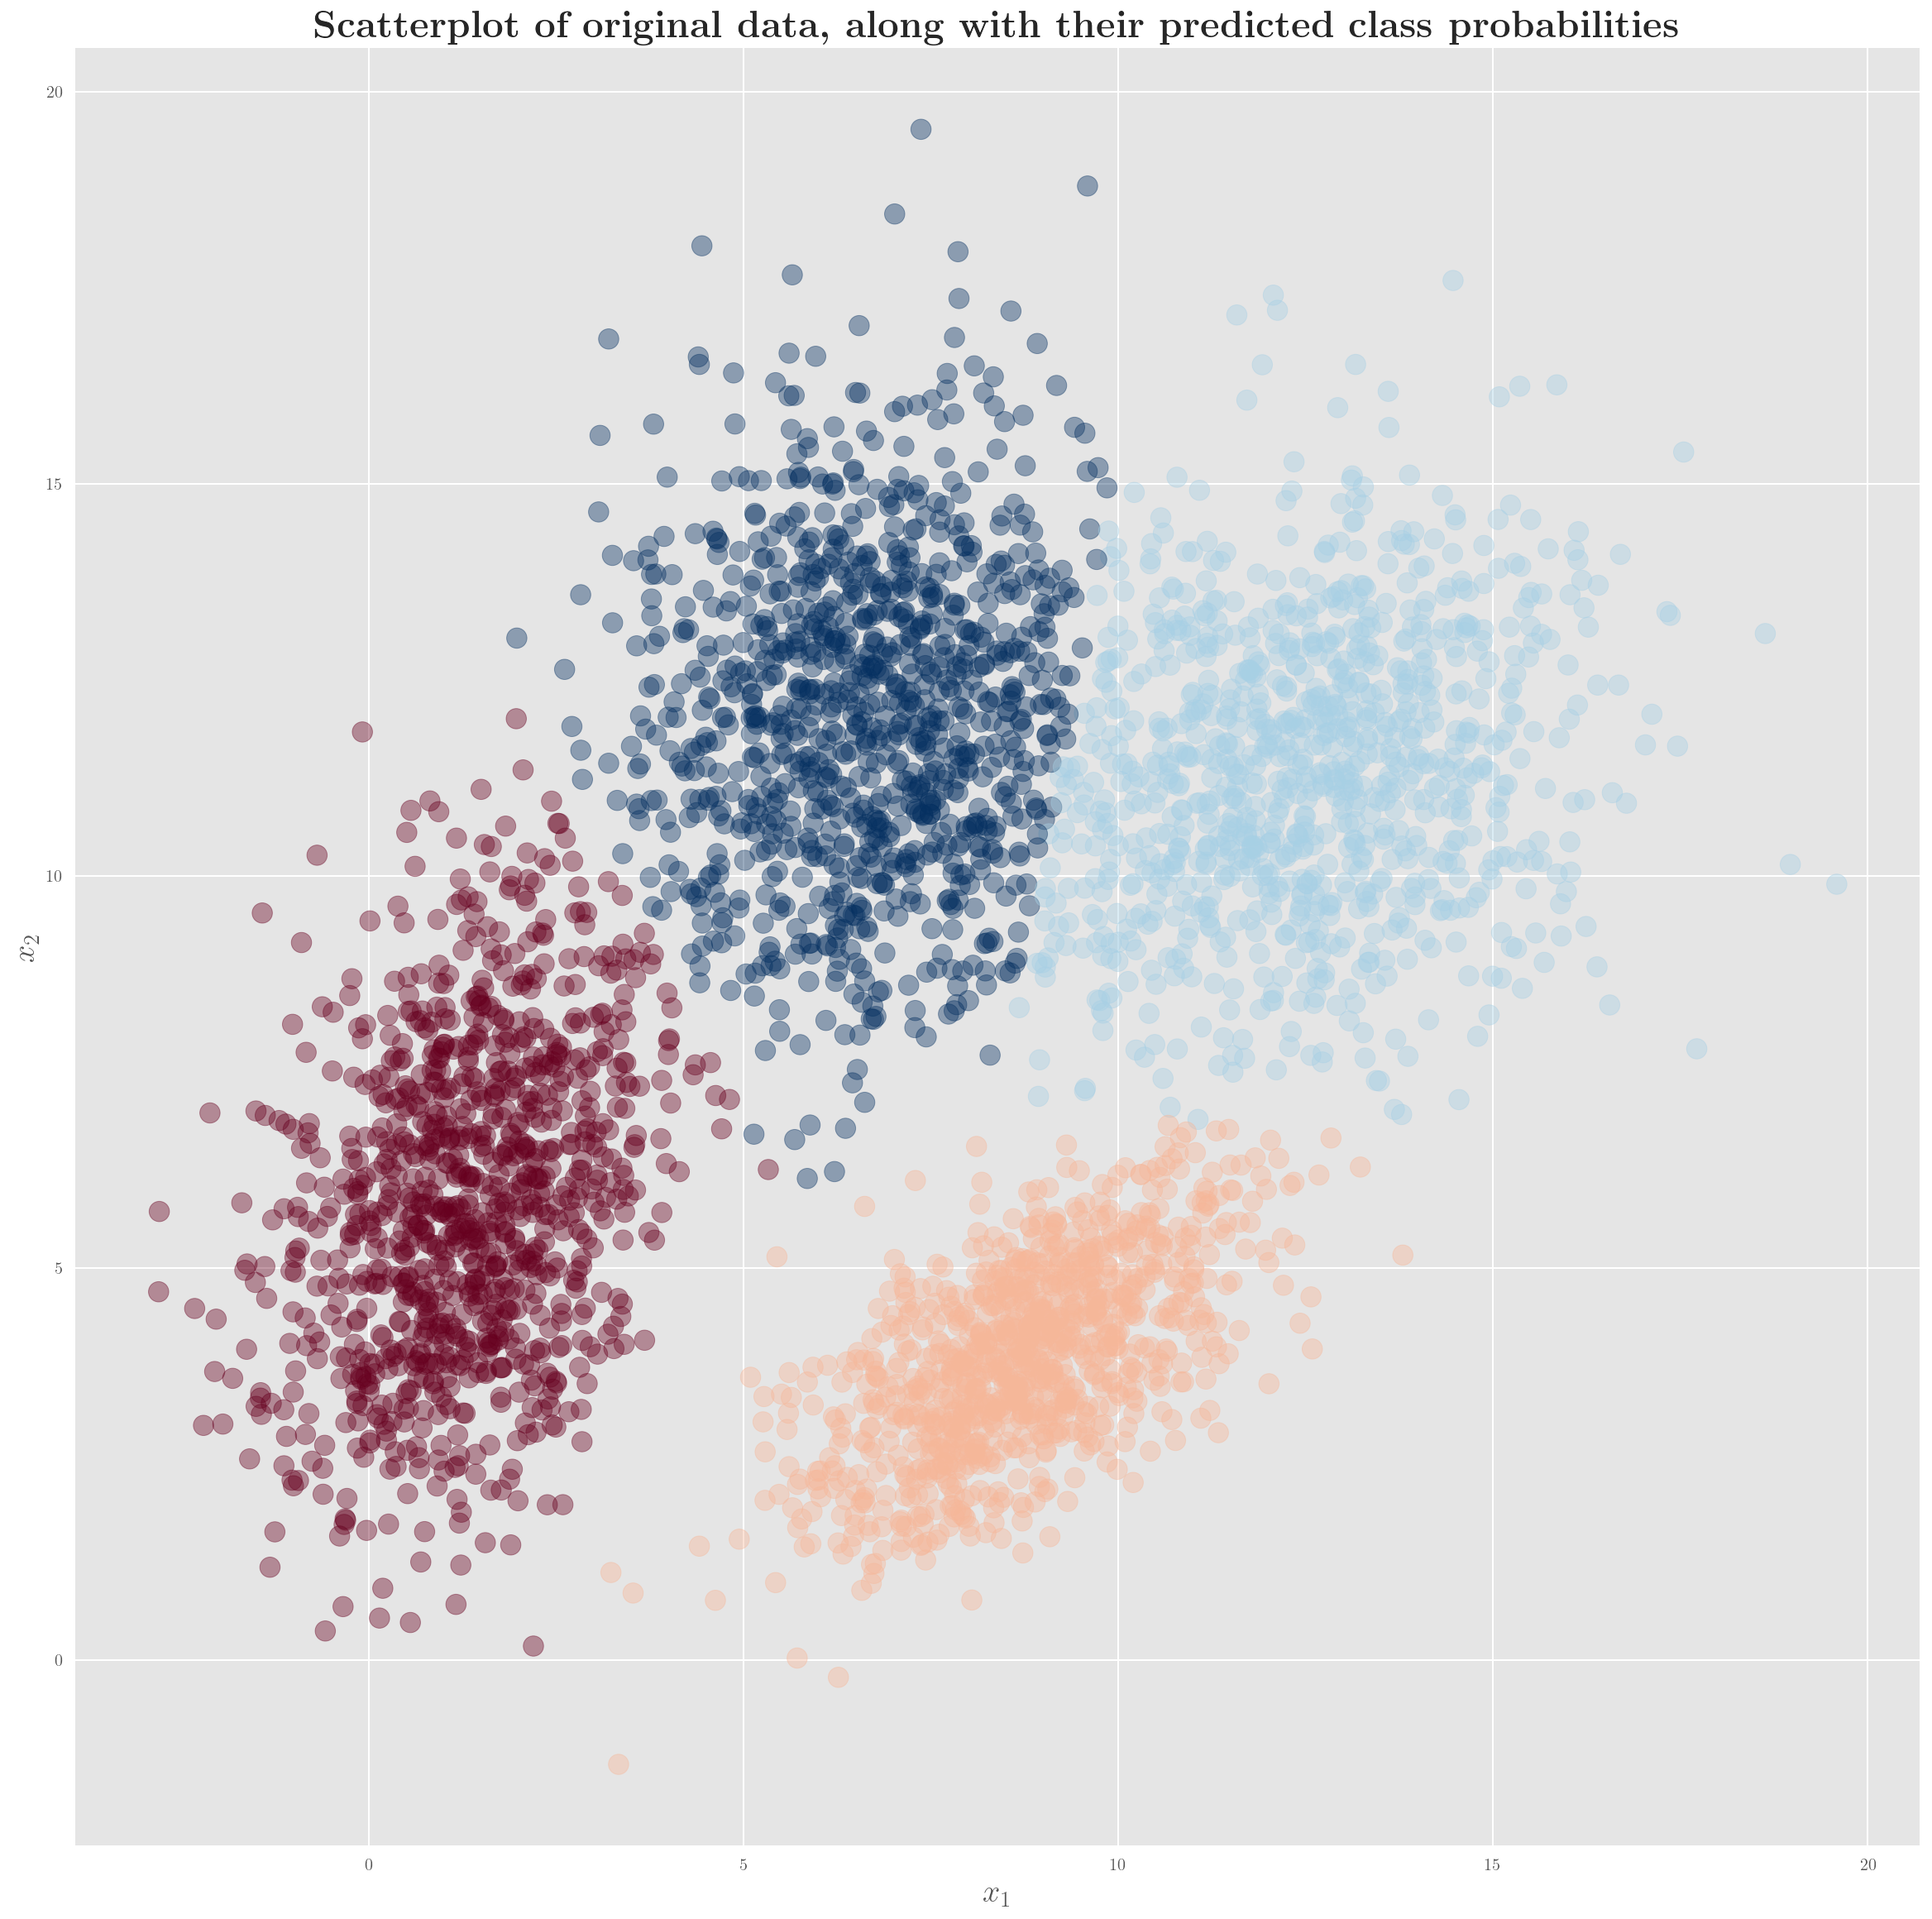

In [16]:
plt.figure(figsize=(20,20))
plt.scatter(X['x1'],   # as the x-axis 
            X['x2'],   # as the y-axis
            s=150,
            alpha=0.4, # size
            c=yhat,
            cmap='RdBu',
            
           )
plt.xlabel (r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r'\textbf{Scatterplot of original data, along with their predicted class probabilities}')


#### Simply drawing the decision-boundary over the points

In [17]:
# In the notation of our text-book:
#
xx    = np.arange(-15,15, 0.1)
beta0 = classifier.intercept_
beta1 = classifier.coef_[0][0]
beta2 = classifier.coef_[0][1]
#
# Decision-Boundary: beta0 + beta1*x + beta2*y = 0
#
line_intercept = -beta0/beta2
line_slope     = -beta1/beta2
print ("intercept: %s, slope %s" % (line_intercept, line_slope))

#
# Equation of line, on
#
yy = line_intercept + line_slope*xx

intercept: [-148.44415678  -60.86081979  167.72133262   41.58364396], slope 25.297986393210216


ValueError: operands could not be broadcast together with shapes (4,) (300,) 

# Linear Discriminant Analysis

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

### Model diagnostics

In [ ]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)

In [ ]:

print(classification_report(y_test, y_pred))

In [ ]:
print("{:15}: {} ".format('Classes',lda.classes_))
print('{:15}: {} '.format('Coefficients',lda.coef_))
print('{:15}: {} '.format('Intercept', lda.intercept_))


### Class Probabilities

In the `sklearn` library, the class probabilities can be seen using the `.predict_proba(X)` method. It returns an array whose rows are the predictions for each row of `X`, and the columns are the class probabilities. In the clase of binary classifier, it is enough to retrieve the proabilities of one of the classes, since the other will be the complement of it.

In [ ]:
predictions = lda.predict_proba(X)[:, 1].reshape(y.shape)
pred_array = lda.predict_proba(X)
yhat=lda.predict(X_test)

In [ ]:
np.argmax(pred_array, axis=1)

The `yellowbrick` library provides a succient visualization of the model metrics.

In [ ]:

fig, axes = plt.subplots(2, 2)

model = lda
visualgrid = [
    FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model,  ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test, )
    viz.finalize()

plt.suptitle(r'\textbf{LDA (Linear Discriminant Analysis) model diagnostics}');
plt.tight_layout();

### Visual model predictions

In [ ]:
visualizer = ROCAUC(model, classes=['0.', '1.', '2,', '3.'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()